In [1]:
%matplotlib inline

Analyze seqFISH data
====================

This tutorial shows how to apply Squidpy for the analysis of seqFISH data.

The data used here was obtained from {cite}`lohoff2020highly`.
We provide a pre-processed subset of the data, in {class}`anndata.AnnData` format.
For details on how it was pre-processed, please refer to the original paper.

Import packages & data
----------------------
To run the notebook locally, create a conda environment as *conda env create -f environment.yml* using this
`environment.yml <https://github.com/scverse/squidpy_notebooks/blob/main/environment.yml>`_.

In [2]:
import numpy as np

import scanpy as sc
import squidpy as sq

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
adata = sq.datasets.seqfish()

/Users/chiaraschiller/miniconda3/envs/squidpy-dev2/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


squidpy==1.6.6.dev2+gafcb8d0.d20250424


First, let's visualize cluster annotation in spatial context
with {func}`squidpy.pl.spatial_scatter`.

/Users/chiaraschiller/Documents/Schapiro/projects/SCNA_thesis/github/squidpy/squidpy_cozi_dev/squidpy/src/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


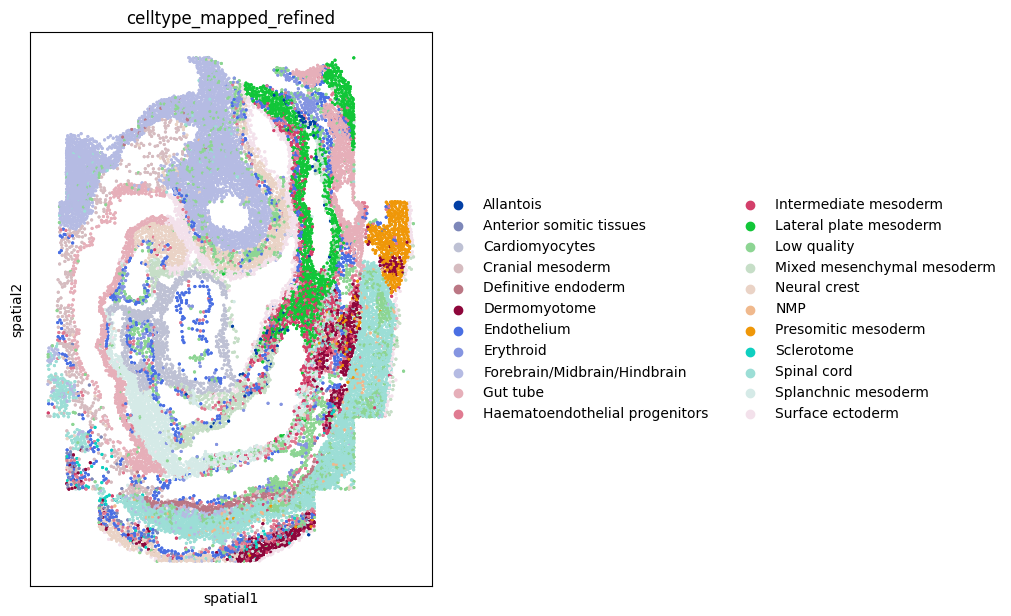

In [3]:
sq.pl.spatial_scatter(
    adata, color="celltype_mapped_refined", shape=None, figsize=(10, 10)
)

Neighborhood enrichment analysis
--------------------------------
Similar to other spatial data, we can investigate spatial organization of clusters
in a quantitative way, by computing a neighborhood enrichment score.
You can compute such score with the following function: {func}`squidpy.gr.nhood_enrichment`.
In short, it's an enrichment score on spatial proximity of clusters:
if spots belonging to two different clusters are often close to each other,
then they will have a high score and can be defined as being *enriched*.
On the other hand, if they are far apart, the score will be low
and they can be defined as *depleted*.
This score is based on a permutation-based test, and you can set
the number of permutations with the `n_perms` argument (default is 1000).

Since the function works on a connectivity matrix, we need to compute that as well.
This can be done with {func}`squidpy.gr.spatial_neighbors`.
Please see {doc}`../examples/graph/compute_spatial_neighbors` for more details
of how this function works.

Finally, we'll directly visualize the results with {func}`squidpy.pl.nhood_enrichment`.
We'll add a dendrogram to the heatmap computed with linkage method *ward*.

  0%|          | 0/1000 [00:00<?, ?/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/chiaraschiller/miniconda3/envs/squidpy-dev2/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


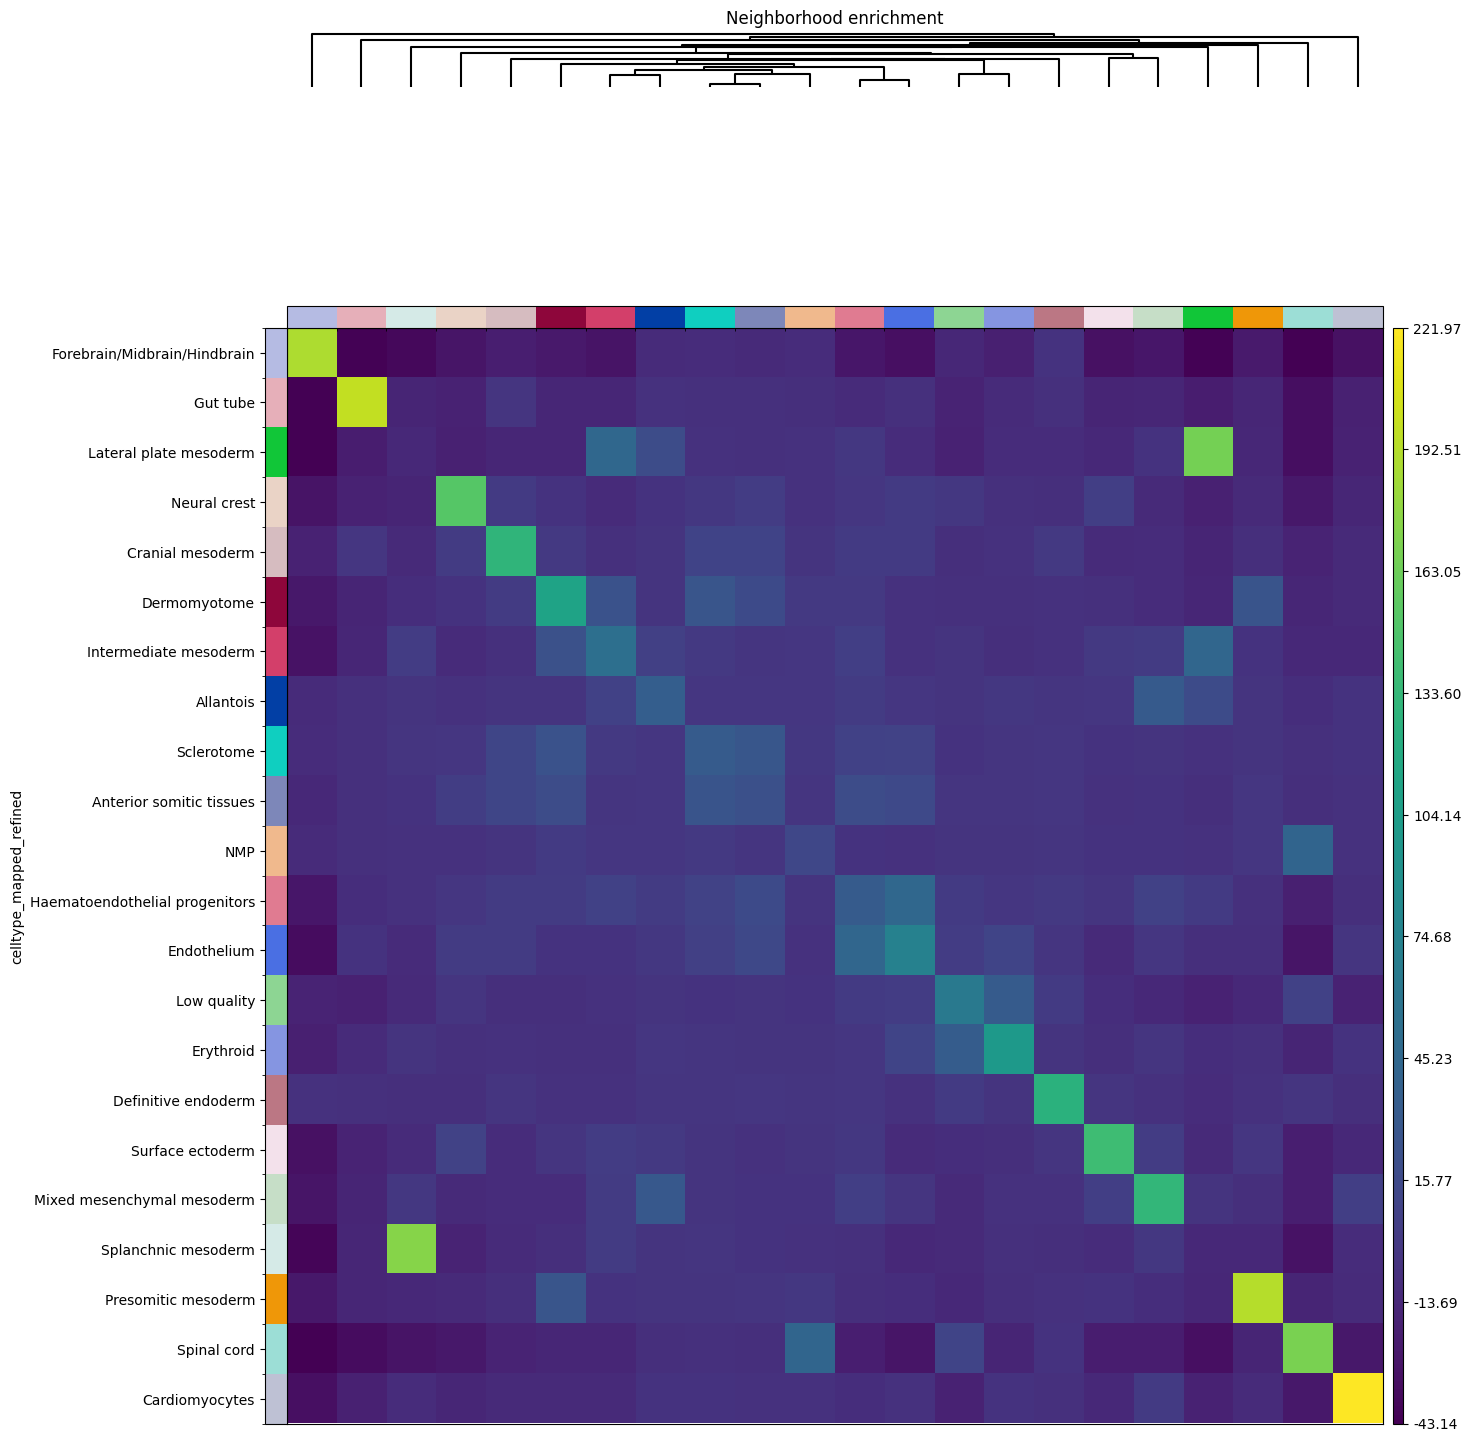

In [4]:
sq.gr.spatial_neighbors(adata, coord_type="generic")
sq.gr.nhood_enrichment(adata, cluster_key="celltype_mapped_refined")
sq.pl.nhood_enrichment(adata, cluster_key="celltype_mapped_refined", method="ward")

A similar analysis was performed in the original publication {cite}`lohoff2020highly`,
and we can appreciate to what extent results overlap.
For instance, there seems to be an enrichment between the *Lateral plate mesoderm*,
the *Intermediate mesoderm* and a milder enrichment for *Allantois* cells.
As in the original publication, there also seems to be an association between the *Endothelium* and
the *Haematoendothelial progenitors*.

The normalization method of the counted neighboring cells in the interaction graph can also be normalizaed conditionally. While the upper method of no normalization gives a global overview
 of cell-cell enrichments without considering directionality in neighbor preferences, conditional normalization allows more fine grained analysis of local and directional neighbor preferences. 

  0%|          | 0/1000 [00:00<?, ?/s]

/Users/chiaraschiller/miniconda3/envs/squidpy-dev2/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


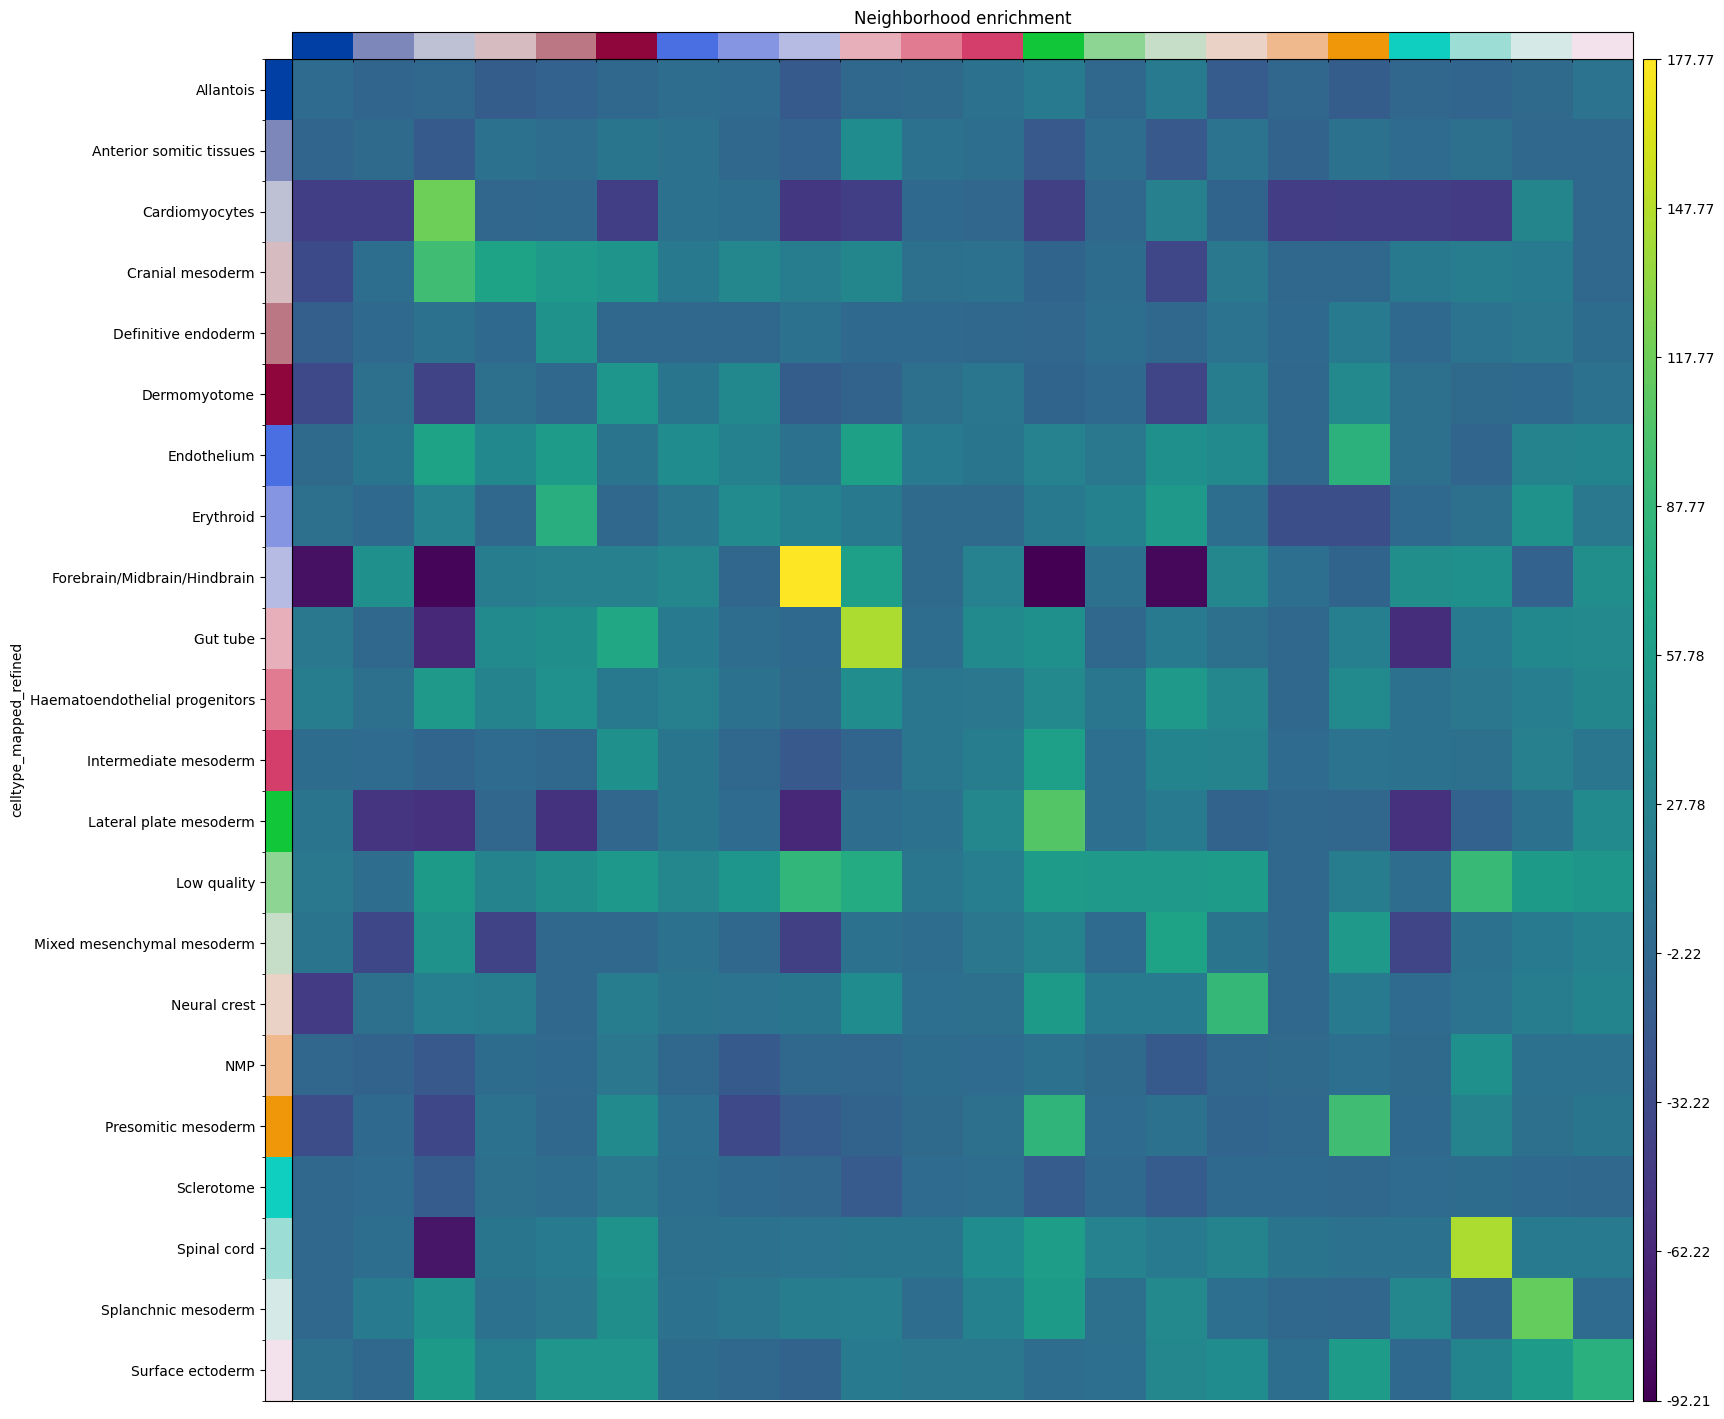

In [13]:
sq.gr.nhood_enrichment(adata, cluster_key="celltype_mapped_refined", normalization="conditional")
sq.pl.nhood_enrichment(adata, cluster_key="celltype_mapped_refined")

As we can already see in the image, the distribution of cell types is very heterogeneous, which we also see in this heatmap. Also here, it is beneficial to know which interactions of interest there are in the dataset. In the heatmap, we for example see that *NMP* surrounds itself with *Spinal cord*, but not vice versa. In the image, we see *NMP* cells lying in the *spinal chord*. In the heatmpa without normalization, we also see this enrichment, but not in a directional way that we know which cell is surrounded by the other. One additional parameter to look at to ease interpretation is the conditional cell ratio (CCR). This is the ratio of cells of an index type that neighbors the other. We can look at that with {func}`sq.pl.nhood_enrichment_dotplot`.

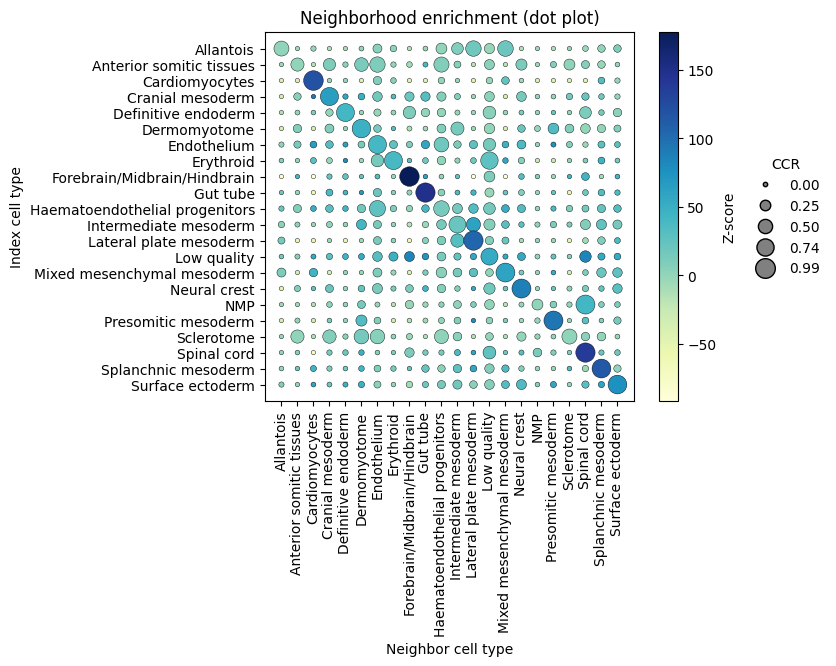

In [6]:
sq.pl.nhood_enrichment_dotplot(adata, cluster_key="celltype_mapped_refined")

For the NMP spinal chord example, we can see that almosy all *NMP* cells neighbor *Spinal chord* cells while only ~20% of *Spinal chord* neighbors *NMP*. 


Of course, results do not perfectly overlap, and this could be due to several factors:

  - the construction of the neighbors graph (which in our case is
    not informed by the radius, as we did not have access to this information).
  - the number of permutation of the neighborhood enrichment
    (500 in the original publication against the default 1000 in our implementation).

We can also visualize the spatial organization of cells again,
and appreciate the proximity of specific cell clusters.
For this, we'll use {func}`squidpy.pl.spatial_scatter` again.

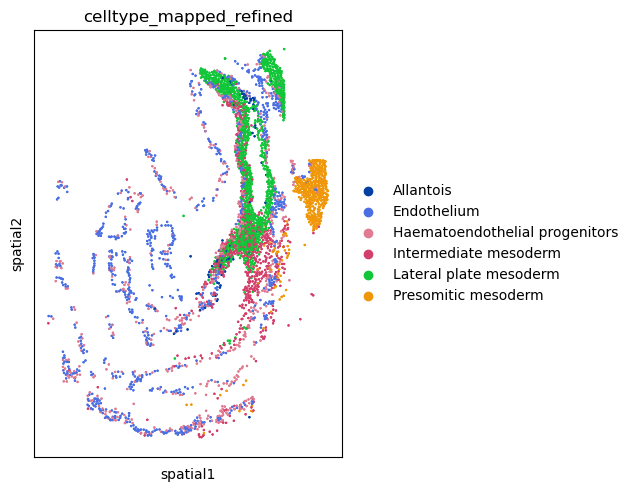

In [6]:
sq.pl.spatial_scatter(
    adata,
    color="celltype_mapped_refined",
    groups=[
        "Endothelium",
        "Haematoendothelial progenitors",
        "Allantois",
        "Lateral plate mesoderm",
        "Intermediate mesoderm",
        "Presomitic mesoderm",
    ],
    shape=None,
    size=2,
)

Co-occurrence across spatial dimensions
---------------------------------------
In addition to the neighbor enrichment score, we can visualize cluster co-occurrence
in spatial dimensions.
This is a similar analysis of the one presented above,
yet it does not operate on the connectivity matrix,
but on the original spatial coordinates.
The co-occurrence score is defined as:

.. math::

    \frac{p(exp|cond)}{p(exp)}

where {math}`p(exp|cond)` is the conditional probability of observing a
cluster {math}`exp` conditioned on the presence of a cluster {math}`cond`, whereas
{math}`p(exp)` is the probability of observing {math}`exp` in the radius size
of interest. The score is computed across increasing radii size
around each cell in the tissue.

We can compute this score with {func}`squidpy.gr.co_occurrence`
and set the cluster annotation for the conditional probability with
the argument ``clusters``. Then, we visualize the results with
{func}`squidpy.pl.co_occurrence`.

100%|██████████| 1/1 [00:37<00:00, 37.70s/]


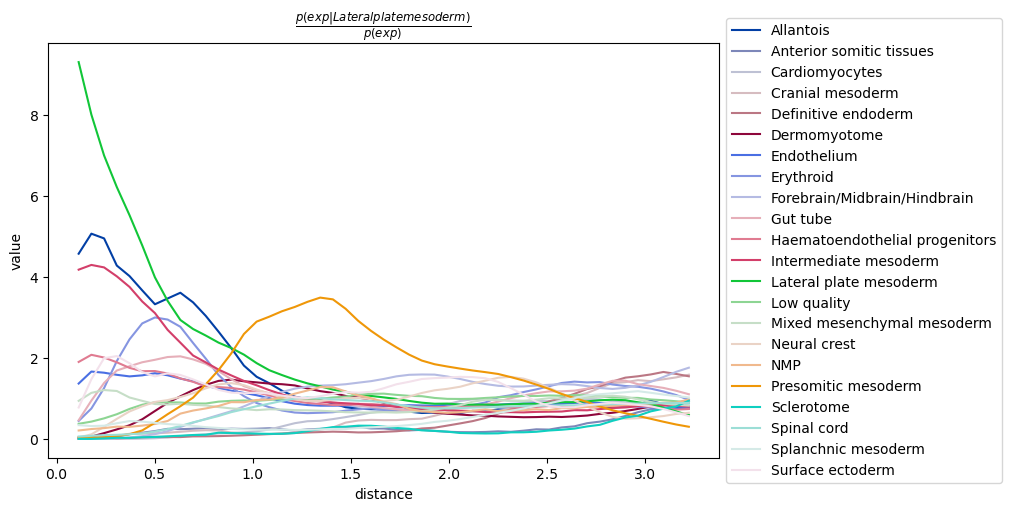

In [7]:
sq.gr.co_occurrence(adata, cluster_key="celltype_mapped_refined")
sq.pl.co_occurrence(
    adata,
    cluster_key="celltype_mapped_refined",
    clusters="Lateral plate mesoderm",
    figsize=(10, 5),
)

It seems to recapitulate a previous observation, that there is a co-occurrence between the
conditional cell type annotation *Lateral plate mesoderm* and the clusters
*Intermediate mesoderm* and *Allantois*.
It also seems that at longer distances, there is a co-occurrence of cells belonging to
the *Presomitic mesoderm* cluster. By visualizing the full tissue as before we can indeed
appreciate that these cell types seems to form a defined clusters relatively close
to the *Lateral plate mesoderm* cells.
It should be noted that the distance units corresponds to
the spatial coordinates saved in `adata.obsm['spatial']`.

Ligand-receptor interaction analysis
------------------------------------
The analysis showed above has provided us with quantitative information on
cellular organization and communication at the tissue level.
We might be interested in getting a list of potential candidates that might be driving
such cellular communication.
This naturally translates in doing a ligand-receptor interaction analysis.
In Squidpy, we provide a fast re-implementation the popular method CellPhoneDB {cite}`cellphonedb`
(`code <https://github.com/Teichlab/cellphonedb>`_)
and extended its database of annotated ligand-receptor interaction pairs with
the popular database *Omnipath* {cite}`omnipath`.
You can run the analysis for all clusters pairs, and all genes (in seconds,
without leaving this notebook), with {func}`squidpy.gr.ligrec`.

Let's perform the analysis and visualize the result for three clusters of
interest: *Lateral plate mesoderm*,
*Intermediate mesoderm* and *Allantois*. For the visualization, we will
filter out annotations
with low-expressed genes (with the ``means_range`` argument)
and decreasing the threshold for the adjusted p-value (with the ``alpha`` argument).

9.39MB [00:00, 26.9MB/s]
1.52MB [00:00, 17.4MB/s]
3.80MB [00:00, 25.3MB/s]
100%|██████████| 100/100 [00:11<00:00,  8.81permutation/s]


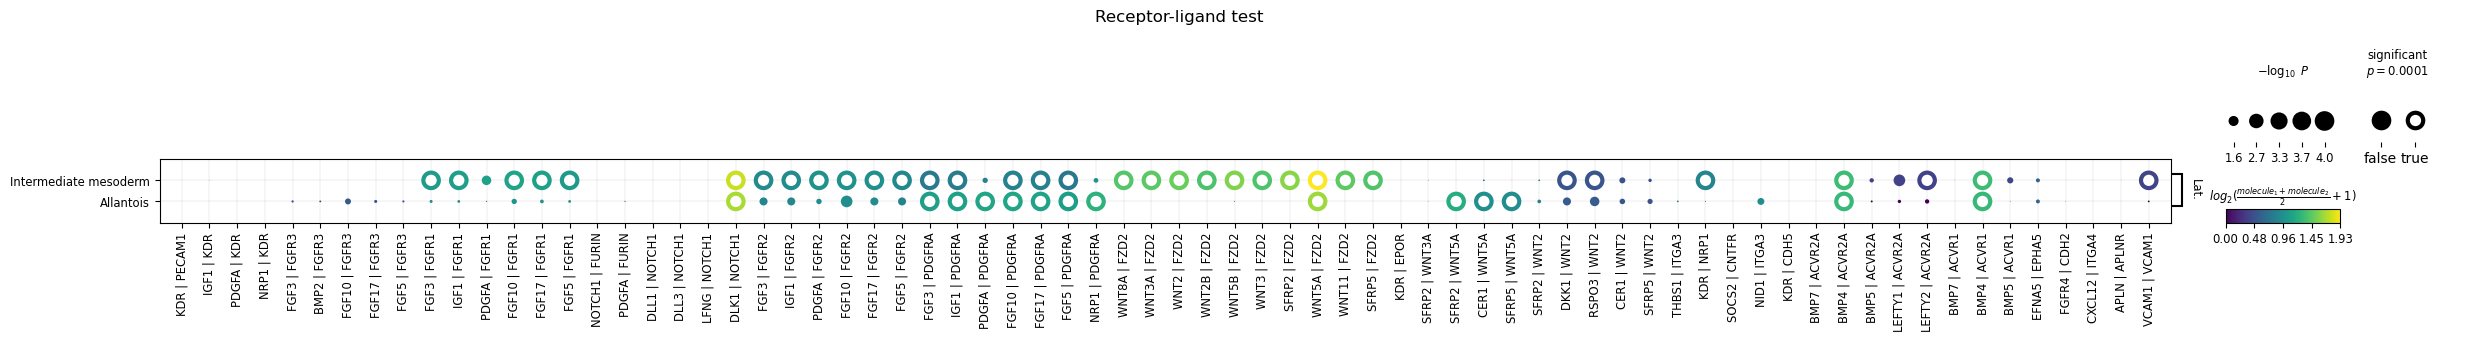

In [8]:
sq.gr.ligrec(
    adata,
    n_perms=100,
    cluster_key="celltype_mapped_refined",
)
sq.pl.ligrec(
    adata,
    cluster_key="celltype_mapped_refined",
    source_groups="Lateral plate mesoderm",
    target_groups=["Intermediate mesoderm", "Allantois"],
    means_range=(0.3, np.inf),
    alpha=1e-4,
    swap_axes=True,
)

The dotplot visualization provides an interesting set of candidate interactions
that could be involved in the tissue organization of the cell types of interest.
It should be noted that this method is a pure re-implementation of the original
permutation-based test, and therefore retains all its caveats
and should be interpreted accordingly.